In [10]:
%matplotlib inline
import os
import frontmatter
import nltk
from nltk.corpus import stopwords
from nltk.stem import porter
import re
from collections import Counter, OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import pandas as pd

In [2]:
files = [frontmatter.load("./transcripts/{}".format(f)) for f in sorted(os.listdir("./transcripts")) if not f.startswith(".")]

In [3]:
docs = [frontmatter.load("./transcripts/{}".format(transcript)).content for transcript in sorted(os.listdir("./transcripts")) if not transcript.startswith(".")]

In [8]:
docs[0][0:100]

"So nice, thank you very much. That's really nice. Thank you. It's great to be at Trump Tower. It's g"

In [11]:
def sanitize(raw_string):
    # Removes all non-alphanumeric characters
    raw_string = re.sub(r"e\-ma", 'ema', raw_string) 
    s = re.sub(r"[^a-zA-Z0-9]+", ' ', raw_string)   
    
    # Replace all numbers
    s = re.sub(r"\d+", ' # ', s)
    
    # Strip white space
    out = " ".join(s.split()).lower()
    return(out)

def get_tokens(text):
    tokens = nltk.word_tokenize(text)
    return(tokens)

stemmer = porter.PorterStemmer()

def stem_tokens(tokens):
    stemmed = [stemmer.stem(t) for t in tokens]
    return(stemmed)

In [13]:
df = pd.DataFrame([f.metadata for f in files])
df["DATETIME"] = pd.to_datetime(df["date"])
lengths = [len(get_tokens(doc)) for doc in docs]
df["length"] = lengths
lengths_df = df[["DATETIME", "length", "type"]].sort_values("DATETIME")
lengths_df.head()

,DATETIME,length,type
0,2015-06-16,8073,speech
1,2015-08-06,2451,debate
2,2015-09-16,4972,debate
3,2015-10-28,1864,debate
4,2015-11-10,2598,debate


In [17]:
def pre_process_docs(docs, stemmed=True):
    documents = []
    for i, doc in tqdm(enumerate(docs), position=0):
        cleaned = sanitize(doc)
        tokens = get_tokens(cleaned)
        filtered = [w for w in tokens if not w in stopwords.words('english')]
        if stemmed==False:
            num_unique = len(filtered)
            processed = " ".join(filtered)
        else:
            stemmed = stem_tokens(filtered)
            processed = " ".join(stemmed)
            num_unique = len(stemmed)
        
        documents.append(processed)
        #print("{: >3} {: <35}: {: <5} tokens".format(i, files[i].metadata["date"], num_unique))
    return(documents)

# Sanitize/Tokenize Transcripts

In [18]:
transcripts = pre_process_docs(docs)

74it [01:03,  1.17it/s]


# Generate Term Frequency Matrix

In [19]:
import pandas as pd
df = pd.DataFrame([f.metadata for f in files])
df["DATETIME"] = pd.to_datetime(df["date"])
del df["date"]
from copy import deepcopy
pdf = deepcopy(df)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_vectorizer = CountVectorizer(max_features=10000, stop_words='english')
tf = tf_vectorizer.fit_transform(transcripts)
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(transcripts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [21]:
speech_tf = pd.DataFrame(tf.todense(), columns=tf_vectorizer.get_feature_names())
speech_tf["DATETIME"] = pdf["DATETIME"]
speech_tf.head()

,abandon,abat,abba,abc,abdullah,abe,abid,abil,abject,abl,...,yorker,young,younger,youngest,youth,yuma,zealot,zero,zone,DATETIME
0,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,6,0,2015-06-16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2015-08-06
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,2015-09-16
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2015-10-28
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2015-11-10


# Combine TF matrix with datetimes; aggregate by time period

In [22]:
fulldf = pd.merge(pdf, speech_tf, on="DATETIME")#.set_index("DATE")

fulldf["year_week"] = fulldf.apply(lambda row: "{}_{}".format(row["DATETIME"].year, row["DATETIME"].isocalendar()[1]), 1)
fulldf["year_month"] = fulldf.apply(lambda row: "{}_{}".format(row["DATETIME"].year, row["DATETIME"].month), 1)

speech_weeks = fulldf.groupby("year_week").sum()
speech_weeks["DATETIME"] = speech_weeks.apply(lambda row: datetime.strptime(row.name + '-0', "%Y_%W-%w"), 1)
speech_weeks = speech_weeks.sort_values("DATETIME")

speech_months = fulldf.groupby("year_month").sum()
speech_months["DATETIME"] = speech_months.apply(lambda row: datetime(int(row.name.split("_")[0]), int(row.name.split("_")[1]), 15), 1)
speech_months = speech_months.sort_values("DATETIME")

# Calculate term _proportion_ matrix

In [23]:
speech_weeks_pct = fulldf.groupby("year_week").sum()
speech_weeks_pct = speech_weeks_pct.apply(lambda col: col.divide(speech_weeks_pct.sum(1)), 0)*100
speech_weeks_pct["DATETIME"] = speech_weeks_pct.apply(lambda row: datetime.strptime(row.name + '-0', "%Y_%W-%w"), 1)
speech_weeks_pct = speech_weeks_pct.sort_values("DATETIME")

speech_months_pct = fulldf.groupby("year_month").sum()
speech_months_pct = speech_months_pct.apply(lambda col: col.divide(speech_months_pct.sum(1)), 0)*100
speech_months_pct["DATETIME"] = speech_months_pct.apply(lambda row: datetime(int(row.name.split("_")[0]), int(row.name.split("_")[1]), 1), 1)
speech_months_pct = speech_months_pct.sort_values("DATETIME")

In [25]:
speech_months_pct["email"]

year_month
2015_6     0.000000
2015_8     0.000000
2015_9     0.000000
2015_10    0.000000
2015_11    0.000000
2015_12    0.000000
2016_1     0.000000
2016_2     0.021322
2016_3     0.000000
2016_4     0.000000
2016_6     0.176491
2016_7     0.220308
2016_8     0.145849
2016_9     0.179480
2016_10    0.326653
2016_11    0.213886
Name: email, dtype: float64

# Plot the data!

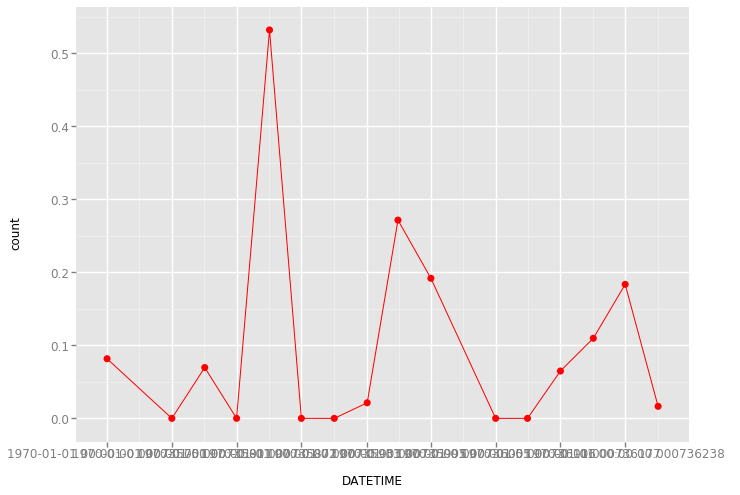

<ggplot: (17078599)>

In [29]:
from ggplot import *

words = ["russia", "putin"]
plot_data = speech_months_pct.loc[:,["DATETIME"] + words]
plot_data["count"] = plot_data.loc[:,words].sum(1)

ggplot(aes(x='DATETIME', y='count'), data=plot_data) + \
    geom_line(color="red") + geom_point(color="red", size=50)

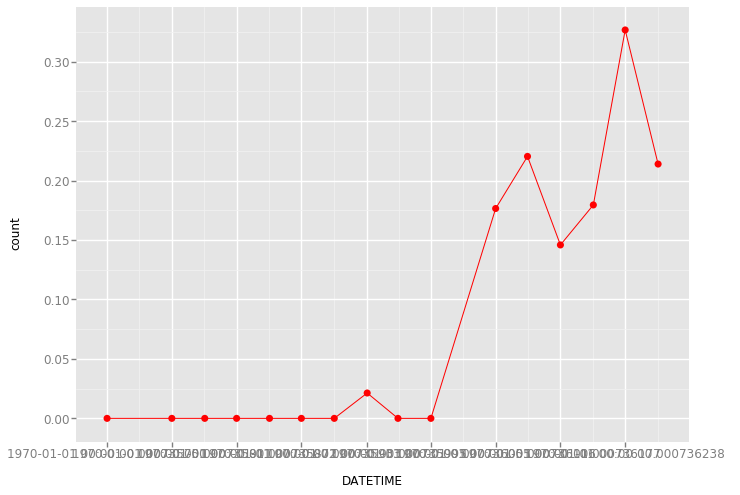

<ggplot: (-9223372036838007843)>

In [28]:
words = ["email"]
plot_data = speech_months_pct.loc[:,["DATETIME"] + words]
plot_data["count"] = plot_data.loc[:,words].sum(1)

ggplot(aes(x='DATETIME', y='count'), data=plot_data) + \
    geom_line(color="red") + geom_point(color="red", size=50)